## Anomaly Detection

This notebook implements and compares common anomaly detection approaches:

1. Gaussian Anomaly Detection (multivariate)
2. Isolation Forest
3. One-Class SVM
4. Local Outlier Factor (LOF)
5. Robust Covariance (EllipticEnvelope)
6. PCA Reconstruction Error
7. Autoencoder (Keras/TensorFlow)


#### Imports & Helpers

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA

np.random.seed(42)


#### Utility Functions

In [17]:
def evaluate_binary(y_true,y_pred,title="Model"):
    """
    Evaluate predictions (0=normal, 1=anomaly).
    """

    precision,recall,f1,_ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average='binary',
        zero_division=0
    )
    cm = confusion_matrix(y_true,y_pred)
    print(f"\n=== {title} ===")
    print("Confusion Matrix:")
    print(cm)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1:        {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=["normal", "anomaly"], zero_division=0))

def plot_2d_results(X, y_true, y_pred, title=""):
    """
    Plot 2D scatter with true labels and predicted anomalies.
    Assumes X has 2 columns.
    """
    plt.figure(figsize=(7, 6))

    # Plot normals (true)
    normal_idx = (y_true == 0)
    plt.scatter(X[normal_idx, 0], X[normal_idx, 1], s=18, alpha=0.6, label="True Normal")

    # Plot true anomalies
    anomaly_idx = (y_true == 1)
    plt.scatter(X[anomaly_idx, 0], X[anomaly_idx, 1], s=30, alpha=0.8, label="True Anomaly")

    # Overlay predicted anomalies with 'x'
    pred_anomaly_idx = (y_pred == 1)
    plt.scatter(X[pred_anomaly_idx, 0], X[pred_anomaly_idx, 1], s=80, marker="x", label="Predicted Anomaly")

    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

def pick_threshold_from_scores(scores, contamination=0.05):
    """
    Convert anomaly scores into a threshold using a contamination ratio.
    Higher score => more anomalous (assumed).

    We select threshold such that top contamination fraction becomes anomalies.
    """
    thresh = np.quantile(scores, 1 - contamination)
    return thresh





#### Dataset Creation

In [18]:
# Create a 2D dataset: normal clusters + injected anomalies
n_normal = 2000
n_anom = 100

# Two Gaussian blobs as normal behavior
mean1, cov1 = [0, 0], [[1.0, 0.3], [0.3, 1.2]]
mean2, cov2 = [5, 5], [[1.2, -0.2], [-0.2, 1.0]]

X1 = np.random.multivariate_normal(mean1, cov1, n_normal // 2)
X2 = np.random.multivariate_normal(mean2, cov2, n_normal // 2)
X_normal = np.vstack([X1, X2])

# Anomalies far away / scattered
X_anom = np.random.uniform(low=-8, high=12, size=(n_anom, 2))

X = np.vstack([X_normal, X_anom])

# Labels: 0=normal, 1=anomaly
y = np.hstack([np.zeros(len(X_normal)), np.ones(len(X_anom))]).astype(int)

# Shuffle
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

print("X shape:", X.shape)
print("Anomaly rate:", y.mean())


X shape: (2100, 2)
Anomaly rate: 0.047619047619047616


#### Train/Test Split + Scaling

In [19]:
X_train, X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.35,random_state=42,stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train anomaly rate:", y_train.mean())
print("Test anomaly rate: ", y_test.mean())

Train anomaly rate: 0.047619047619047616
Test anomaly rate:  0.047619047619047616


### Gaussian Anomaly Detection (Multivariate)

Idea:
- Assume normal data follows a multivariate Gaussian distribution N(μ, Σ).
- Fit μ and Σ using *only normal data* (or mostly-normal training).
- Compute probability density p(x) for each point.
- Low probability => anomaly.

In practice:
- We compute log-likelihood (more stable than raw probability).
- Choose a threshold epsilon (e.g. using contamination ratio or validation).



=== Gaussian (Multivariate) ===
Confusion Matrix:
[[695   5]
 [  4  31]]
Precision: 0.8611
Recall:    0.8857
F1:        0.8732

Classification report:
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99       700
     anomaly       0.86      0.89      0.87        35

    accuracy                           0.99       735
   macro avg       0.93      0.94      0.93       735
weighted avg       0.99      0.99      0.99       735



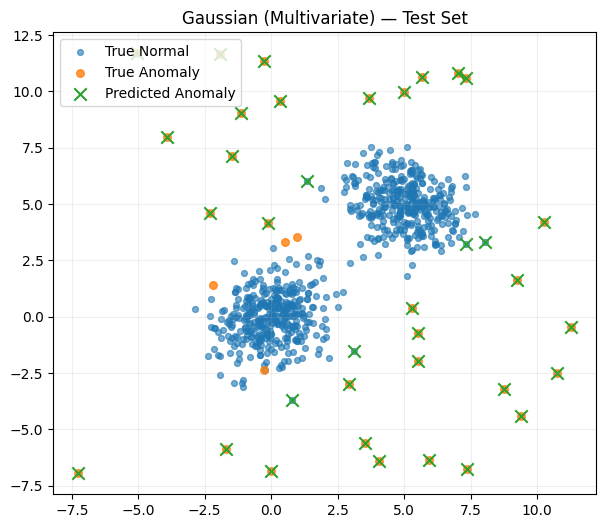

In [20]:
def fit_gaussian(X):
     """
    Fit multivariate Gaussian parameters (mu, cov).
    """
     mu = np.mean(X,axis=0)
     cov = np.cov(X.T)

     return mu,cov

def gaussian_logpdf(X, mu, cov):
    """
    Compute multivariate Gaussian log-pdf for each row of X.
    """
    d = X.shape[1]
    cov_inv = np.linalg.inv(cov)
    det = np.linalg.det(cov)

    # small stability fix (in case det is tiny)
    det = max(det, 1e-12)

    diff = X - mu
    # Mahalanobis distance: (x-mu)^T Sigma^-1 (x-mu)
    mahal = np.sum(diff @ cov_inv * diff, axis=1)

    log_norm = -0.5 * (d * np.log(2*np.pi) + np.log(det))
    logp = log_norm - 0.5 * mahal
    return logp


# Fit Gaussian mostly on normal points only (since we have labels here)
X_train_norm = X_train_scaled[y_train == 0]

mu, cov = fit_gaussian(X_train_norm)

# For anomalies, we want "higher score = more anomalous"
# Gaussian gives logp where LOW logp is more anomalous, so score = -logp
train_logp = gaussian_logpdf(X_train_scaled, mu, cov)
test_logp = gaussian_logpdf(X_test_scaled, mu, cov)

train_scores = -train_logp
test_scores = -test_logp

contamination = y_train.mean()  # we know the true rate here; in real life you estimate it
thresh = pick_threshold_from_scores(train_scores, contamination=contamination)

y_pred = (test_scores >= thresh).astype(int)

evaluate_binary(y_test, y_pred, title="Gaussian (Multivariate)")
plot_2d_results(X_test, y_test, y_pred, title="Gaussian (Multivariate) — Test Set")

#### Isolation Forest Algorithm

Idea:
1. Build many random trees (called isolation trees).
2. For each tree:
    - Pick a random feature
    - Pick a random split value within that feature’s min/max
    - Split the data and repeat recursively
3. For a given point, measure its path length = number of splits needed until it lands in a leaf (or is isolated).
4. Average path length across all trees:
    - short path → point got isolated quickly → likely anomaly
    - long path → needs many splits → likely normal
5. Convert this into an anomaly score, and classify top “contamination” fraction as anomalies.

Pros:
- Fast, scalable, works well on many real datasets.
- Does not assume Gaussian distribution.



=== IsolationForest ===
Confusion Matrix:
[[700   0]
 [ 28   7]]
Precision: 1.0000
Recall:    0.2000
F1:        0.3333

Classification report:
              precision    recall  f1-score   support

      normal       0.96      1.00      0.98       700
     anomaly       1.00      0.20      0.33        35

    accuracy                           0.96       735
   macro avg       0.98      0.60      0.66       735
weighted avg       0.96      0.96      0.95       735



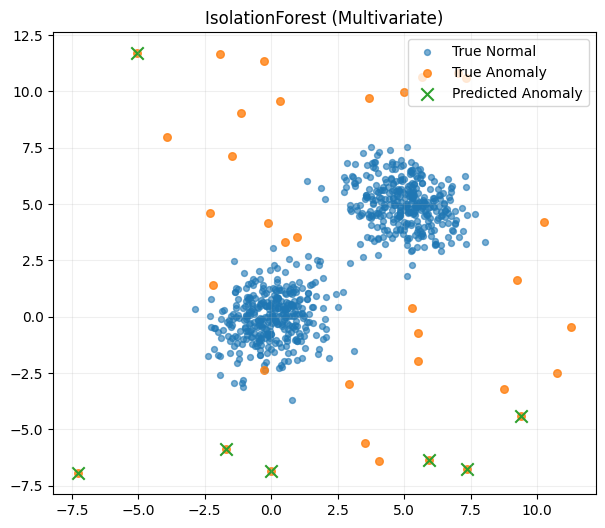

In [23]:
iso = IsolationForest(
    n_estimators=300,
    contamination=y_train.mean(),
    random_state=42,
)

iso.fit(X_train)

pred_raw = iso.predict(X_test_scaled)
y_pred = (pred_raw==-1).astype(int)

evaluate_binary(y_test, y_pred, title="IsolationForest")
plot_2d_results(X_test, y_test, y_pred, title="IsolationForest (Multivariate)")